In [ ]:
pip install tomlkit

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Note: you may need to restart the kernel to use updated packages.


In [28]:
pip install optuna

   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ------------------------ --------------- 1.3/2.1 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 9.2 MB/s  0:00:00

   ---------------------------------------- 0/8 [PyYAML]
   ---------- ----------------------------- 2/8 [greenlet]
   --------------- ------------------------ 3/8 [colorlog]
   -------------------- ------------------- 4/8 [sqlalchemy]
   -------------------- ------------------- 4/8 [sqlalchemy]
   -------------------- ------------------- 4/8 [sqlalchemy]
   -------------------- ------------------- 4/8 [sqlalchemy]
   -------------------- ------------------- 4/8 [sqlalchemy]
   -------------------- ------------------- 4/8 [sqlalchemy]
   -------------------- ------------------- 4/8 [sqlalchemy]
   -------------------- ------------------- 4/8 [sqlalchemy]
   -------------------- ------------------- 4/8 [sqlalchemy]
   -------------------- ------------------- 4/8 [sqlalche

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


# **FASE 3**

In [1]:
import pandas as pd
import os
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df_train = pd.read_csv(os.path.join("..", "data", "dataset_train_final.csv"))
df_test = pd.read_csv(os.path.join("..", "data", "dataset_test_final.csv"))
df_val = pd.read_csv(os.path.join("..", "data", "dataset_val_final.csv"))

(906, 31)

**3.1 Modelos Requeridos Entrenar y comparar al menos 4 modelos:**   
- XGBoost
- Random Forest Regressor
- LightGBM
- Ridge/Lasso Regression

In [3]:
X_train_noval = df_train.drop(columns=['y'])
y_train_noval = df_train['y']

X_val = df_val.drop(columns=['y'])
y_val = df_val['y']

X_test = df_test.drop(columns=['y'])
y_test = df_test['y']

X_train = pd.concat([X_train_noval, X_val])
y_train = pd.concat([y_train_noval, y_val])

In [4]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tomlkit import datetime
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit


LOG_FILE = os.path.join("..", "results", "experiment_logs.csv")
# Crear la carpeta si no existe
os.makedirs(os.path.dirname(LOG_FILE), exist_ok=True)

def log_experiment(model_name, params, metrics):
    """
    Registra una ejecución de un modelo en el archivo CSV.
    """
    # Preparar la data para el log
    log_data = {
        #'timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'model_name': model_name,
        'mae': metrics['mae'],
        'rmse': metrics['rmse'],
        'r2': metrics['r2'],
        'params': str(params) # Guardar hiperparámetros como string
    }
    
    # Convertir a DataFrame para facilitar la escritura
    log_df = pd.DataFrame([log_data])
    
    # Escribir en el CSV
    if not os.path.exists(LOG_FILE):
        # Si el archivo no existe, escribir con header
        log_df.to_csv(LOG_FILE, index=False, mode='w')
    else:
        # Si ya existe, añadir sin header
        log_df.to_csv(LOG_FILE, index=False, mode='a', header=False)

def calculate_metrics(y_true, y_pred):
    """Calcula las métricas de regresión."""
    return {
        'mae': mean_absolute_error(y_true, y_pred),
        
        # --- ESTA ES LA LÍNEA CORREGIDA ---
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        
        'r2': r2_score(y_true, y_pred)
    }

In [6]:
# 1. Definir modelos y espacios de búsqueda (¡ajusta estos rangos!)
models_to_train = {
    'Ridge': {
        'model': Ridge(),
        'params': {'alpha': [0.1, 1.0, 10.0]}
    },
    'Lasso': {
        'model': Lasso(),
        'params': {'alpha': [0.1, 1.0, 10.0]}
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1]
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=42, force_col_wise=True, verbose=-1),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1]
        }
    }
}

# 2. Bucle de entrenamiento y logging
best_models = {} # Para guardar los mejores modelos de GridSearchCV

print("Iniciando entrenamiento y optimización...")

for model_name, config in models_to_train.items():
    print(f"--- Entrenando {model_name} ---")
    
    # Configurar GridSearchCV
    # Usará 'neg_mean_absolute_error' para optimizar, ya que MAE es tu métrica objetivo
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        scoring='neg_mean_absolute_error', # GridSearchCV busca maximizar, por eso usamos el negativo
        cv=TimeSeriesSplit(n_splits=3),
        verbose=1
    )
    
    # Entrenar
    grid_search.fit(X_train, y_train)
    
    # Obtener el mejor modelo y sus parámetros
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # 3. Evaluar en el conjunto de VALIDACIÓN
    y_pred_val = best_model.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred_val)
    
    # 4. Registrar el experimento (Sección 3.2)
    log_experiment(model_name, best_params, metrics)
    
    # Guardar el mejor modelo para el siguiente paso
    best_models[model_name] = best_model
    
    print(f"Resultados de {model_name}:")
    print(f"  Mejores Parámetros: {best_params}")
    print(f"  MAE (Test): {metrics['mae']:.4f}")
    print(f"  R2 (Test): {metrics['r2']:.4f}")
    print("-" * 30)

print("Entrenamiento completado. Logs guardados en results/experiment_logs.csv")

Iniciando entrenamiento y optimización...
--- Entrenando Ridge ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Resultados de Ridge:
  Mejores Parámetros: {'alpha': 10.0}
  MAE (Test): 2628.3891
  R2 (Test): 0.6209
------------------------------
--- Entrenando Lasso ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\out6let\miniconda3\envs\cervecera_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.206e+08, tolerance: 1.328e+06
  model = cd_fast.enet_coordinate_descent(
c:\Users\out6let\miniconda3\envs\cervecera_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.308e+09, tolerance: 2.707e+06
  model = cd_fast.enet_coordinate_descent(
c:\Users\out6let\miniconda3\envs\cervecera_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

Resultados de Lasso:
  Mejores Parámetros: {'alpha': 10.0}
  MAE (Test): 2665.8444
  R2 (Test): 0.6129
------------------------------
--- Entrenando RandomForest ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Resultados de RandomForest:
  Mejores Parámetros: {'max_depth': 10, 'n_estimators': 200}
  MAE (Test): 2584.5655
  R2 (Test): 0.6223
------------------------------
--- Entrenando XGBoost ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Resultados de XGBoost:
  Mejores Parámetros: {'learning_rate': 0.1, 'n_estimators': 100}
  MAE (Test): 2817.6132
  R2 (Test): 0.5551
------------------------------
--- Entrenando LightGBM ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Resultados de LightGBM:
  Mejores Parámetros: {'learning_rate': 0.1, 'n_estimators': 100}
  MAE (Test): 2800.1294
  R2 (Test): 0.5625
------------------------------
Entrenamiento completado. Logs guardados en results/experiment_logs.csv


Mejor modelo según MAE de validación: RandomForest
MAE: 2568.0565
Parámetros: {'max_depth': 10, 'n_estimators': 200}


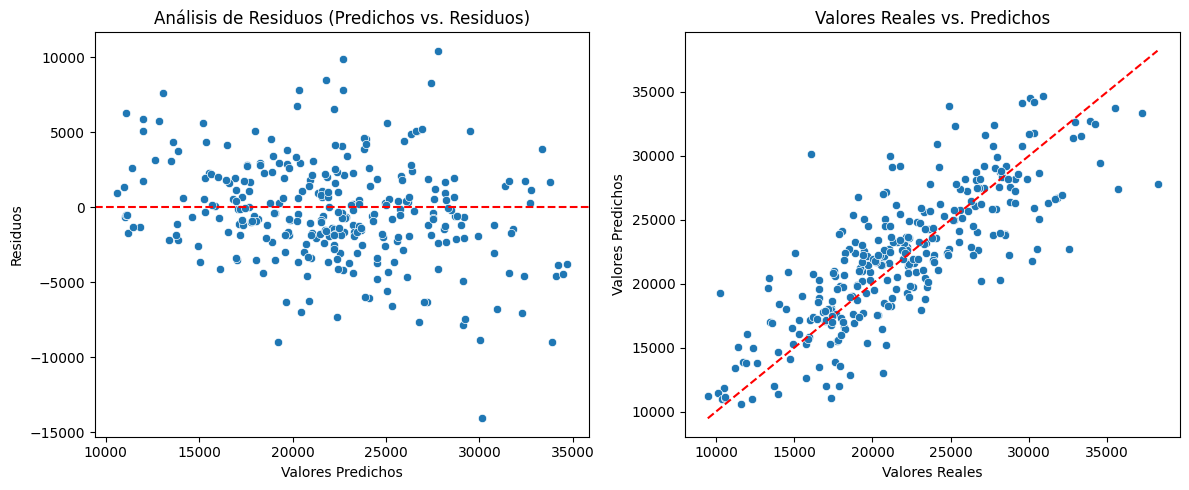

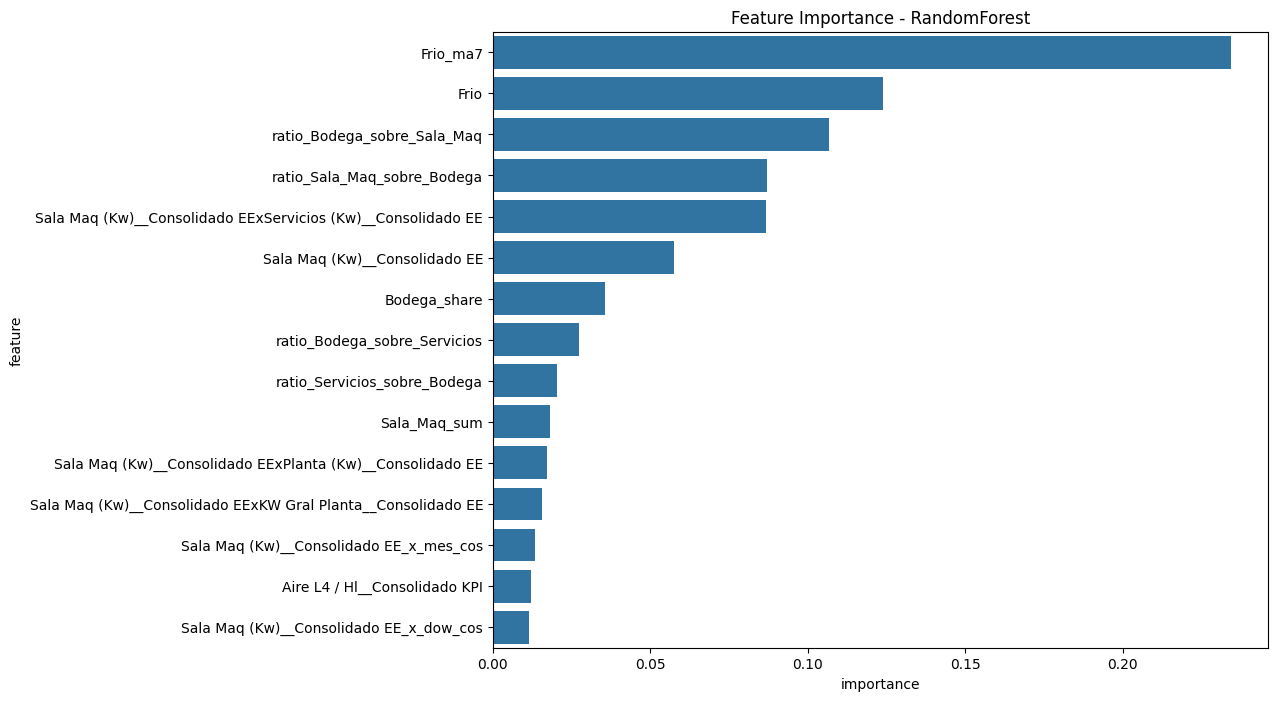

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Cargar logs y seleccionar el mejor modelo
log_df = pd.read_csv(LOG_FILE)
# Ordenar por MAE (ascendente) para encontrar el mejor
best_model_log = log_df.sort_values('mae').iloc[0]

BEST_MODEL_NAME = best_model_log['model_name']
best_model_from_grid = best_models[BEST_MODEL_NAME] # Recuperar el modelo entrenado de nuestro diccionario

print(f"Mejor modelo según MAE de validación: {BEST_MODEL_NAME}")
print(f"MAE: {best_model_log['mae']:.4f}")
print(f"Parámetros: {best_model_log['params']}")

# 2. Análisis de Residuos
y_pred_best = best_model_from_grid.predict(X_test)
residuals = y_test - y_pred_best

plt.figure(figsize=(12, 5))

# Gráfico de Residuos vs. Predicciones
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_best, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Análisis de Residuos (Predichos vs. Residuos)')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')

# Gráfico de Valores Reales vs. Predicciones
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_best)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') # Línea y=x
plt.title('Valores Reales vs. Predichos')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')

plt.tight_layout()
plt.show()

# 3. Feature Importance (Solo para modelos de árbol)
if BEST_MODEL_NAME in ['RandomForest', 'XGBoost', 'LightGBM']:
    importances = best_model_from_grid.feature_importances_
    feature_names = X_train.columns
    
    # Crear un DataFrame para facilitar el gráfico
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).head(15) # Top 15
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title(f'Feature Importance - {BEST_MODEL_NAME}')
    plt.show()

In [18]:
# 0. Instalar e Importar
import optuna
import warnings
import joblib
import json
import os
import datetime
import subprocess

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error 

# --- (Asegúrate de que estas variables estén CARGADAS) ---
# X_train_noval, y_train_noval (SOLO train)
# X_val, y_val (SOLO val)
# X_train, y_train (train + val combinado)
# X_test, y_test
# -------------------------------------------------------------------------


BEST_MODEL_NAME = 'RandomForestRegressor' 

optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore", category=FutureWarning)


# 1. Definir la Función "Objective"
def objective(trial):
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 5, 50, log=True),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1) 

    # 1.2 Evaluar el modelo (¡SOLO CON DATOS DE "solo train"!)
    scores = cross_val_score(
        model, 
        X_train_noval,  # <-- CAMBIO CLAVE: Usamos el set "solo train"
        y_train_noval,  # <-- CAMBIO CLAVE:
        cv=TimeSeriesSplit(n_splits=3), 
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    
    mae = -scores.mean()
    return mae

# 2. Ejecutar el Estudio de Optimización
print(f"🔎 Iniciando optimización con Optuna para: {BEST_MODEL_NAME}...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100) 

print("Optimización de Optuna finalizada.")
print(f"Mejor MAE (CV en X_train_noval): {study.best_value:.4f}")

# 3. Recuperar los mejores parámetros encontrados
best_params_dict = study.best_params
print(f"Mejores Hiperparámetros encontrados: \n{json.dumps(best_params_dict, indent=2)}")


# 4. Validar estos parámetros en el set "hold-out" (X_val)
print("\nValidando parámetros de Optuna en el set hold-out (X_val)...")

model_val = RandomForestRegressor(**best_params_dict, random_state=42, n_jobs=-1)

# Entrenamos solo en X_train_noval
model_val.fit(X_train_noval, y_train_noval) # <-- CAMBIO CLAVE

# Predecimos en X_val
y_pred_val = model_val.predict(X_val) # <-- Usamos el set de validación

best_mae_val = mean_absolute_error(y_val, y_pred_val) # <-- Comparamos con y_val
print(f"MAE (Validación final): {best_mae_val:.4f}")


# 5. Instanciar el modelo FINAL y Re-entrenar con TODOS los datos (X_train)
print(f"\nRe-entrenando {BEST_MODEL_NAME} con datos completos (Train + Val)...")

# Usamos el set combinado que llamaste X_train / y_train
model_final = RandomForestRegressor(**best_params_dict, random_state=42, n_jobs=-1)
model_final.fit(X_train, y_train) # <-- CAMBIO CLAVE: Usamos el set combinado

print("Modelo final re-entrenado y listo para usar en X_test.")
# (Ahora puedes usar model_final.predict(X_test))

🔎 Iniciando optimización con Optuna para: RandomForestRegressor...
Optimización de Optuna finalizada.
Mejor MAE (CV en X_train_noval): 3250.5472
Mejores Hiperparámetros encontrados: 
{
  "n_estimators": 900,
  "max_depth": 14,
  "min_samples_leaf": 6,
  "min_samples_split": 3,
  "max_features": 0.12980098724187808,
  "bootstrap": true
}

Validando parámetros de Optuna en el set hold-out (X_val)...
MAE (Validación final): 2867.0984

Re-entrenando RandomForestRegressor con datos completos (Train + Val)...
Modelo final re-entrenado y listo para usar en X_test.


In [19]:
y_pred_test = model_final.predict(X_test)

# 2. Calcular las métricas finales
final_metrics = calculate_metrics(y_test, y_pred_test)

print("\n--- ¡MÉTRICAS FINALES (X_test vs y_test)! ---")
print(f"  MAE (Error Promedio): {final_metrics['mae']:.4f}")
print(f" RMSE (Error Cuadrático): {final_metrics['rmse']:.4f}")
print(f"   R² (Coef. Determinación): {final_metrics['r2']:.4f}")


--- ¡MÉTRICAS FINALES (X_test vs y_test)! ---
  MAE (Error Promedio): 2738.0179
 RMSE (Error Cuadrático): 3552.4337
   R² (Coef. Determinación): 0.5877


In [13]:
pip install tensorboardX

Note: you may need to restart the kernel to use updated packages.


In [14]:
import xgboost as xgb
import os
import shutil
from torch.utils.tensorboard import SummaryWriter

    
import xgboost as xgb
from tensorboardX import SummaryWriter  # o torch.utils.tensorboard si tenés PyTorch

class TensorBoardCallback(xgb.callback.TrainingCallback):
    def __init__(self, log_dir, metric_name="mae"):
        self.writer = SummaryWriter(log_dir)
        self.metric_name = metric_name

    def after_iteration(self, model, epoch, evals_log):
        # Guardar todas las métricas que XGBoost calcula
        for data_name, metrics in evals_log.items():
            for metric, values in metrics.items():
                if len(values) > 0:
                    self.writer.add_scalar(f"{data_name}/{metric}", values[-1], epoch)
        self.writer.flush()
        return False

    def after_training(self, model):
        # Cerrar el writer al terminar el entrenamiento
        self.writer.close()
        return model


# --- CONFIGURACIÓN ---
LOG_DIR = "./logs/xgb_run_1"

if os.path.exists(LOG_DIR):
    print(f"Borrando logs antiguos de: {LOG_DIR}")
    shutil.rmtree(LOG_DIR)
print(f"Guardando logs de TensorBoard en: {LOG_DIR}")
os.makedirs(LOG_DIR, exist_ok=True)

# --- CALLBACK ---
tensorboard_callback = TensorBoardCallback(LOG_DIR, metric_name="mae")

# --- MODELO ---
model_xgb = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    early_stopping_rounds=50,
    random_state=42,
    n_jobs=-1,
    callbacks=[tensorboard_callback],
    eval_metric="mae"  # ✅ agregalo acá
)

# --- ENTRENAMIENTO ---
print("Entrenando XGBoost con callback de TensorBoard...")

model_xgb.fit(
    X_train_noval,
    y_train_noval,
    eval_set=[
        (X_train_noval, y_train_noval),
        (X_val, y_val)
    ],
    verbose=100
)

print("¡Entrenamiento de XGBoost completo!")

print("\n--- ¡Acción Requerida! ---")
print("1. Abre una NUEVA terminal.")
print("2. Navega (cd) a la carpeta donde corriste este script.")
print(f"3. Ejecuta el siguiente comando:\n")
print(f"tensorboard --logdir={LOG_DIR}\n")
print("4. Abre http://localhost:6006/ en tu navegador.")


Borrando logs antiguos de: ./logs/xgb_run_1
Guardando logs de TensorBoard en: ./logs/xgb_run_1
Entrenando XGBoost con callback de TensorBoard...
[0]	validation_0-mae:6442.04686	validation_1-mae:6225.06789
[100]	validation_0-mae:860.28171	validation_1-mae:3085.83643
[115]	validation_0-mae:777.97784	validation_1-mae:3098.72225
¡Entrenamiento de XGBoost completo!

--- ¡Acción Requerida! ---
1. Abre una NUEVA terminal.
2. Navega (cd) a la carpeta donde corriste este script.
3. Ejecuta el siguiente comando:

tensorboard --logdir=./logs/xgb_run_1

4. Abre http://localhost:6006/ en tu navegador.


In [ ]:
#----------

final_model = Lasso(**best_params_dict)

# Re-entrenamos con TODO (X, y)
final_model.fit(X_train, y_train) # <-- Esta línea ahora funcionará
print("Re-entrenamiento finalizado.")

# 6. Implementar versionado semántico y Guardar
VERSION = "v1.0.0" # Tu primera versión
MODEL_DIR = os.path.join("..", "models")
MODEL_PATH = os.path.join(MODEL_DIR, f"modelo_{VERSION}.pkl")
REGISTRY_PATH = os.path.join(MODEL_DIR, "model_registry.json")

os.makedirs(MODEL_DIR, exist_ok=True)

joblib.dump(final_model, MODEL_PATH)
print(f"Modelo guardado en: {MODEL_PATH}")

# 7. Crear el registro local (model_registry.json)
try:
    commit_hash = subprocess.check_output(['git', 'rev-parse', 'HEAD']).decode('ascii').strip()
except Exception as e:
    print(f"Advertencia: No se pudo obtener el hash de Git. {e}")
    commit_hash = "N/A"

model_registry_entry = {
    'version': VERSION,
    'model_name': BEST_MODEL_NAME,
    'model_path': os.path.relpath(MODEL_PATH, os.path.join("..")), 
    'git_commit_hash': commit_hash,
    'trained_timestamp': datetime.datetime.now().isoformat(),
    'final_hyperparameters': best_params_dict,   # <-- DE OPTUNA
    'validation_metrics': best_metrics_dict      # <-- DE LA VALIDACIÓN EN X_val
}

if os.path.exists(REGISTRY_PATH):
    with open(REGISTRY_PATH, 'r') as f:
        registry_data = json.load(f)
else:
    registry_data = {}

registry_data[VERSION] = model_registry_entry

with open(REGISTRY_PATH, 'w') as f:
    json.dump(registry_data, f, indent=4)

print(f"Registro de modelo actualizado en: {REGISTRY_PATH}")

# --- Asumimos que el mejor fue 'LightGBM' --- ¡DEBES AJUSTAR ESTO!
# Esto debería ser dinámico, pero para el script lo haré manual
# basado en la salida de la celda anterior (BEST_MODEL_NAME)

# 1. Recuperar los hiperparámetros del log (el string)
#    Usamos 'eval()' para convertir el string del log de nuevo a un diccionario
best_params_dict = eval(best_model_log['params'])
best_metrics_dict = best_model_log[['mae', 'rmse', 'r2']].to_dict()

# 2. Instanciar el modelo final (ej. LightGBM)
#    ¡¡CAMBIA ESTO por el modelo que ganó!!

final_model = Lasso(**best_params_dict)

print(f"Re-entrenando {BEST_MODEL_NAME} con datos completos (train+val)...")
# 3. Re-entrenar con TODOS los datos de df_train (X, y)
final_model.fit(X, y)

print("Re-entrenamiento finalizado.")

# 4. Implementar versionado semántico
VERSION = "v1.0.0" # Tu primera versión
MODEL_DIR = os.path.join("..", "models")
MODEL_PATH = os.path.join(MODEL_DIR, f"modelo_{VERSION}.pkl")
REGISTRY_PATH = os.path.join(MODEL_DIR, "model_registry.json")

os.makedirs(MODEL_DIR, exist_ok=True)

# 5. Guardar el modelo serializado
joblib.dump(final_model, MODEL_PATH)
print(f"Modelo guardado en: {MODEL_PATH}")

# 6. Crear el registro local (model_registry.json)

# Obtener el hash de Git
try:
    commit_hash = subprocess.check_output(['git', 'rev-parse', 'HEAD']).decode('ascii').strip()
except Exception as e:
    print(f"Advertencia: No se pudo obtener el hash de Git. {e}")
    commit_hash = "N/A"

# Crear la entrada del registro
model_registry_entry = {
    'version': VERSION,
    'model_name': BEST_MODEL_NAME,
    'model_path': os.path.relpath(MODEL_PATH, os.path.join("..")), # Ruta relativa
    'git_commit_hash': commit_hash,
    'trained_timestamp': datetime.datetime.now().isoformat(),
    'final_hyperparameters': best_params_dict,
    'validation_metrics': best_metrics_dict
}

# Cargar el registro existente (si hay) o crear uno nuevo
if os.path.exists(REGISTRY_PATH):
    with open(REGISTRY_PATH, 'r') as f:
        registry_data = json.load(f)
else:
    registry_data = {}

# Añadir o sobrescribir la entrada de esta versión
registry_data[VERSION] = model_registry_entry

# Guardar el JSON actualizado
with open(REGISTRY_PATH, 'w') as f:
    json.dump(registry_data, f, indent=4)

print(f"Registro de modelo actualizado en: {REGISTRY_PATH}")